<h1><b>AI Computer Assignment 3</b></h1>
<h3>FatemeZahra Broumandnia</h3>
<h3>SID : 810100094</h3>

### Problem Description
*In this project, we aim to analyze and decompose images of various flowers using clustering algorithms. Our goal is to categorize them into different clusters based on the data we have, so that after applying the clustering algorithm, they are ideally placed within their respective clusters.*

### Goal
*The goal of this project is to utilize clustering algorithms for the analysis and categorization of images depicting various types of flowers. By applying these algorithms, we seek to accurately group the images into clusters that reflect their intrinsic similarities, effectively organizing them based on their visual features.*

In [2]:
import os
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16, preprocess_input
from sklearn.cluster import KMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, homogeneity_score

In [3]:
folder_path = "G:/Uni/Uni6/AI/A3/flower_images"
num_images_to_display = 5
eps = 100
min_samples = 2 

## *Preprocess*

In [4]:
import os
import cv2
import numpy as np

def read_and_preprocess_images(folder_path, target_size=(224, 224), saturation_factor=1.5, contrast_factor=1):
    images = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)

            if img is not None:
                
                img = cv2.convertScaleAbs(img, alpha=contrast_factor, beta=0)

                
                img_hsv = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
                
                
                img_hsv[:,:,1] = np.clip(img_hsv[:,:,1] * saturation_factor, 0, 255)
                
               
                lower_green = np.array([35, 50, 50])
                upper_green = np.array([90, 255, 255])
                lower_blue = np.array([90, 50, 50])
                upper_blue = np.array([130, 255, 255])
                lower_soil = np.array([0, 50, 20])
                upper_soil = np.array([30, 255, 255])
                lower_brown = np.array([10, 50, 20])
                upper_brown = np.array([20, 255, 255])

                
                mask_green = cv2.inRange(img_hsv, lower_green, upper_green)
                mask_blue = cv2.inRange(img_hsv, lower_blue, upper_blue)
                mask_soil = cv2.inRange(img_hsv, lower_soil, upper_soil)
                mask_brown = cv2.inRange(img_hsv, lower_brown, upper_brown)
                mask_bg = cv2.bitwise_or(mask_green, mask_blue, mask_soil, mask_brown)

                
                img[mask_bg != 0] = [0, 0, 0]

                img_resized = cv2.resize(img, target_size)
                images.append(img_resized)

    return np.array(images, dtype=np.uint8)


In [5]:
labels_df = pd.read_csv("G:/Uni/Uni6/AI/A3/flower_images/flower_labels.csv")
true_labels = labels_df['label']

### Question 1: What is the reason for extracting features? Why do we not rely solely on reading pixels? Explain.
Extracting features from images using a model such as VGG16 serves a crucial purpose: it enables the capture of more sophisticated visual representations embedded within the images. Unlike simply analyzing pixel values, this approach delves into deeper semantic meanings and abstract features essential for tasks such as image classification or clustering.

By eliminating the fully connected layers of the VGG16 model and focusing on feature extraction from the convolutional layers, we achieve a streamlined representation of the images. This streamlined representation retains vital visual information while filtering out extraneous details. This extraction process not only reduces the complexity of the data, making it more manageable for subsequent analysis, but it also enhances the efficacy of clustering algorithms. By furnishing these algorithms with meaningful and discriminative features, it enables the grouping of similar images with greater precision.


### Question 2: Research and provide a brief explanation of three techniques for extracting features from images.

There exist three prominent methodologies for extracting features, namely:

1. *Convolutional Neural Networks (CNNs)*: CNNs autonomously acquire hierarchical representations of visual features through intricate layers such as convolutional and pooling layers. They demonstrate proficiency in capturing a wide array of features including edges, textures, and shapes. These networks are typically trained on extensive datasets using methodologies such as transfer learning.
2. *Histogram of Oriented Gradients (HOG):* HOG focuses on the gradient information within images by computing histograms of gradient orientations within localized image cells. It proves valuable in tasks like pedestrian detection and object recognition.
3. *Scale-Invariant Feature Transform (SIFT):* SIFT identifies salient points within images and generates descriptors that encapsulate local gradient orientations and magnitudes. It excels in scenarios involving variations in scale, rotation, and illumination, and finds widespread application in tasks such as image stitching and object recognition.


These methodologies empower machines to effectively interpret visual data, thereby facilitating tasks such as image classification, object detection, and content-based image retrieval.


### Question 3: What preprocessing should be done on images before they are ready to be fed into a model?

In [6]:
images = read_and_preprocess_images(folder_path)
base_model = VGG16(weights='imagenet', include_top=False,pooling='avg')
features = base_model.predict(images)

7/7 ━━━━━━━━━━━━━━━━━━━━ 27s 4s/step


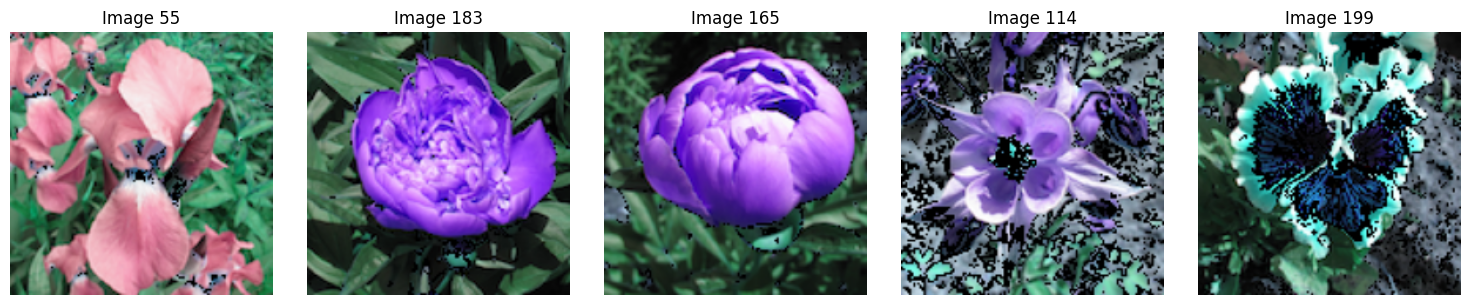

In [7]:
plt.figure(figsize=(15, 3))
random_indices = random.sample(range(len(images)), num_images_to_display)
for i, random_index in enumerate(random_indices):
    plt.subplot(1, num_images_to_display, i + 1)
    plt.imshow(images[random_index])
    plt.title("Image " + str(random_index + 1))
    plt.axis('off')

plt.tight_layout()
plt.show()

## *Clustering Algorithm Implementation*

### Question 4: Describe the K-Means and DBSCAN methods, along with their advantages and disadvantages compared to each other.

**K-Means Algorithm:**

The K-Means algorithm operates through iterative assignment of data points to the nearest cluster centroid, followed by centroid updates based on the mean of the data points within each cluster until convergence.

#### Advantages:
1. Implementation simplicity and ease.
2. High efficiency, especially with large datasets.
3. Scalability to accommodate a vast number of samples.

#### Disadvantages:
1. Dependence on a predefined number of clusters (k).
2. Vulnerability to initialization sensitivity, potentially converging to local optima.
3. Assumption of clusters being spherical and uniform in size, which may not universally apply.

**DBSCAN (Density-Based Spatial Clustering of Applications with Noise):**

DBSCAN identifies clusters based on density connectivity, grouping closely packed data points while isolating regions of low density. It initiates by selecting a point and determining its neighboring points within a specified distance (epsilon, ε). If the neighbor count surpasses a threshold, the point qualifies as a core point, initiating cluster expansion.

#### Advantages:
1. Elimination of the need for a predefined cluster count.
2. Capability to handle clusters of diverse shapes and sizes.
3. Resilience to noise and outliers.

#### Disadvantages:
1. Sensitivity to the choice of distance metric and epsilon parameter.
2. Potential challenges with varying density clusters or high-dimensional data.
3. Computational intensity, particularly with sizable datasets.

## K-means Algorithm:

### Question 5: What method have you used to find the most suitable K in the K-Means method? Explain.
To ascertain the most appropriate value of K for the K-Means clustering technique, I employed the elbow method. This method entails plotting the sum of squared distances (inertia) of data points to their closest cluster centroids against various values of K. As K rises, the inertia typically declines, since each cluster tends to encompass more data points. Nevertheless, beyond a certain threshold, augmenting K does not substantially decrease the inertia, resulting in diminishing returns. The optimal K value is often discerned at the "elbow" juncture in the plot, where the rate of inertia reduction noticeably decelerates. This indicates a balance between minimizing inertia and preventing overfitting. Thus, the elbow method furnishes a straightforward yet efficacious heuristic for determining the suitable number of clusters for K-Means clustering.

c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows wi

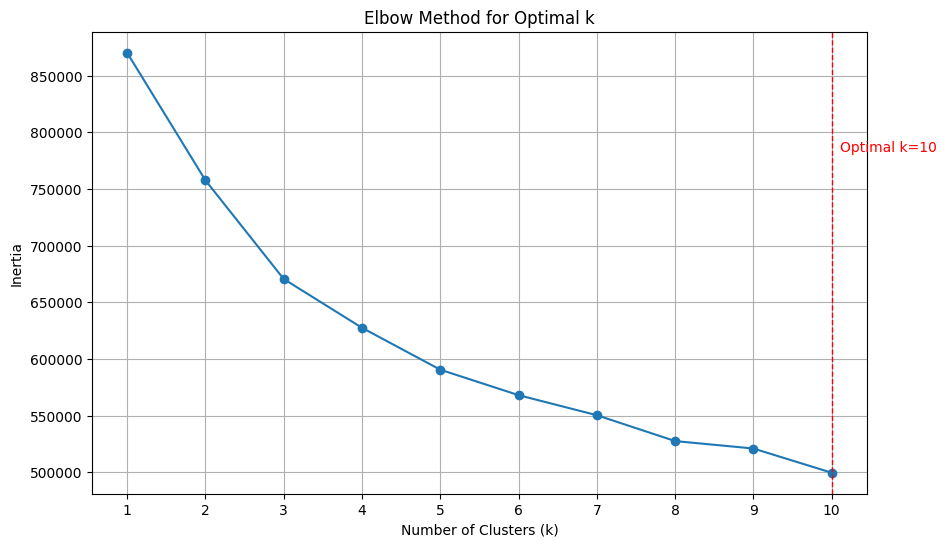

In [8]:
inertia_values = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, n_init=10)  
    kmeans.fit(features.reshape(features.shape[0], -1))
    inertia_values.append(kmeans.inertia_)

diff = np.diff(inertia_values)
diff_r = diff[1:] / diff[:-1]
optimal_k = np.argmin(diff_r) + 2
optimal_k = 10

plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.xticks(range(1, 11))
plt.grid(True)

plt.axvline(x=optimal_k, color='r', linestyle='--', linewidth=1)
plt.text(optimal_k + 0.1, max(inertia_values) * 0.9, f'Optimal k={optimal_k}', color='r')
plt.show()

In [9]:
optimal_k = 10
kmeans = KMeans(n_clusters=10, n_init=10)
kmeans.fit(features.reshape(features.shape[0], -1)) 
cluster_labels = kmeans.labels_

c:\Users\Asus\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(


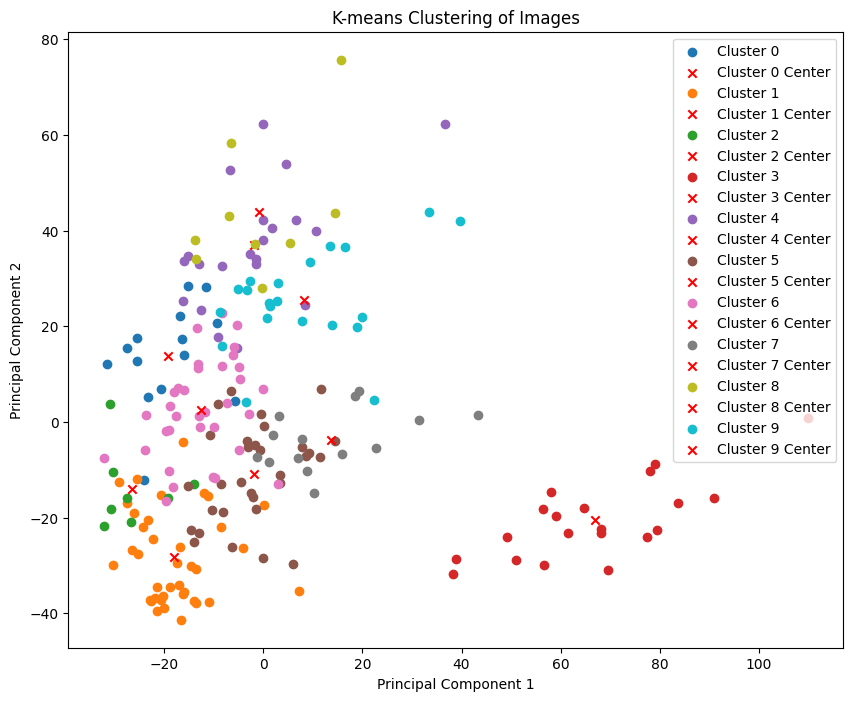

In [10]:
pca = PCA(n_components=2)
pca_features = pca.fit_transform(features.reshape(features.shape[0], -1))
plt.figure(figsize=(10, 8))

for cluster_id in range(optimal_k):
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    plt.scatter(pca_features[cluster_indices, 0], pca_features[cluster_indices, 1], label=f'Cluster {cluster_id}')

    cluster_center = np.mean(pca_features[cluster_indices], axis=0)
    plt.scatter(cluster_center[0], cluster_center[1], marker='x', color='red', label=f'Cluster {cluster_id} Center')

plt.title('K-means Clustering of Images')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

In [11]:
silhouette = silhouette_score(features.reshape(features.shape[0], -1), cluster_labels)
print("Silhouette Score:", silhouette)

homogeneity = homogeneity_score(true_labels, cluster_labels)
print("Homogeneity Score:", homogeneity)

Silhouette Score: 0.11005917
Homogeneity Score: 0.5251955052023116


C:\Users\Asus\AppData\Local\Temp\ipykernel_29812\2109725578.py:18: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


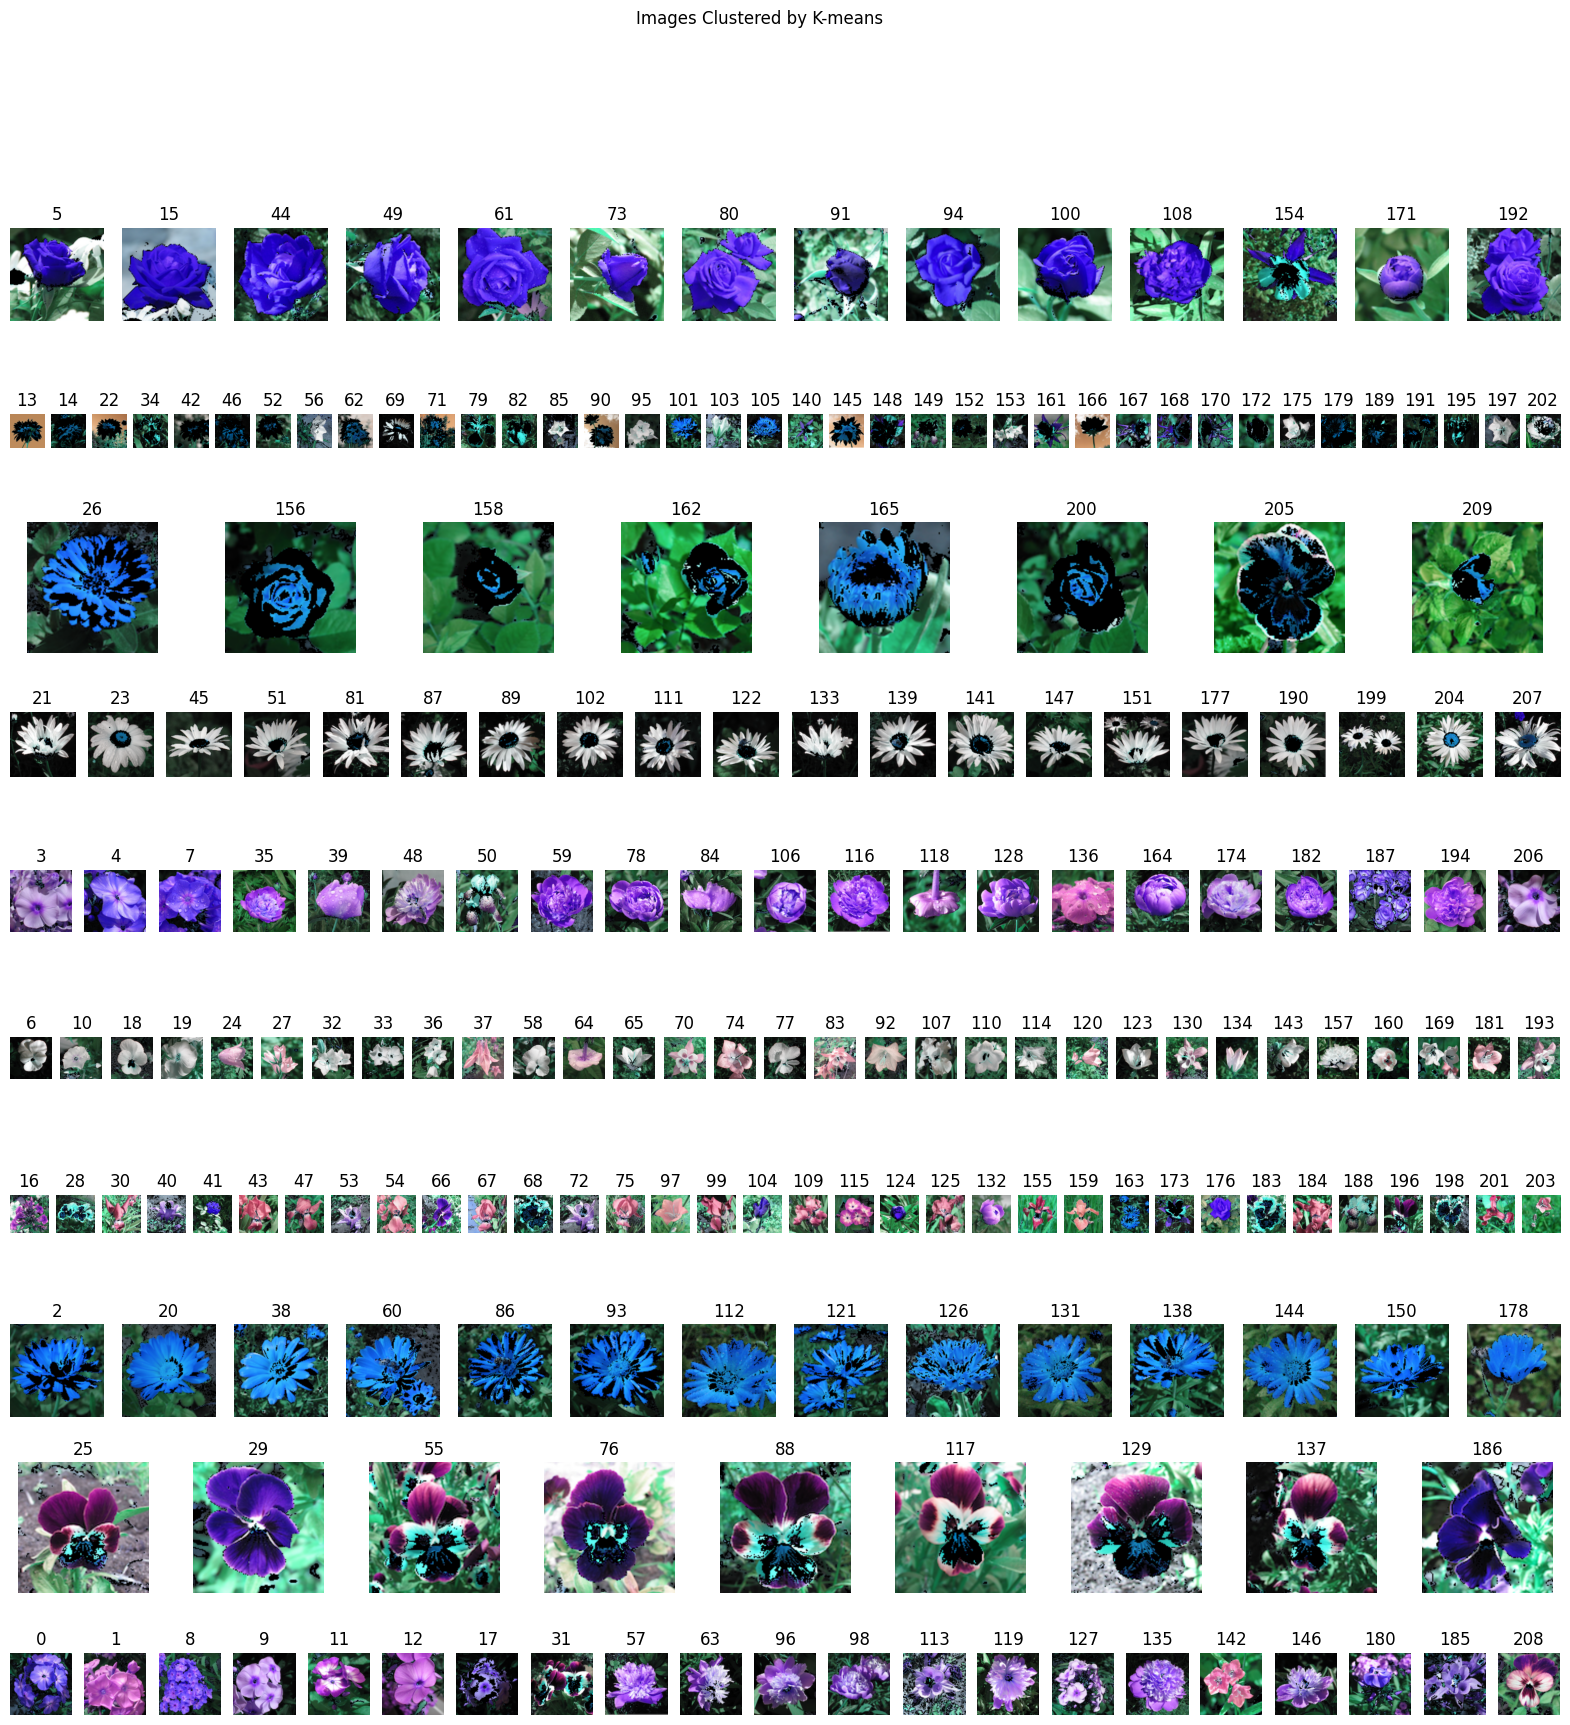

In [12]:
plt.figure(figsize=(20, 20))


for cluster_id in range(optimal_k):
    cluster_indices = np.where(cluster_labels == cluster_id)[0]
    cluster_images = images[cluster_indices] 
    cluster_indices = cluster_indices[:len(cluster_images)]  
    num_images = len(cluster_images)

    
    for i in range(num_images):
        plt.subplot(optimal_k, num_images, i + 1 + cluster_id * num_images)
        plt.imshow(cluster_images[i])
        plt.axis('off')
        plt.title(f'{cluster_indices[i]}')

plt.suptitle('Images Clustered by K-means')
plt.tight_layout()
plt.show()


## DBSCAN Algorithm:

In [13]:
def read_and_preprocess_images(folder_path, target_size=(224, 224)):
    images = []

    for filename in os.listdir(folder_path):
        if filename.endswith(".png"):
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)

            if img is not None:
                img_resized = cv2.resize(img, target_size)
                images.append(img_resized)

    return np.array(images, dtype=np.float32)

In [14]:
images = read_and_preprocess_images(folder_path)
base_model = VGG16(weights='imagenet', include_top=False)
features = base_model.predict(images)

7/7 ━━━━━━━━━━━━━━━━━━━━ 28s 4s/step


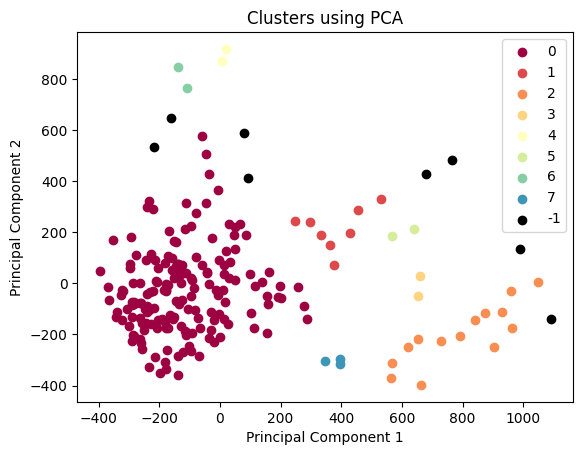

In [15]:

n_samples, height, width, channels = features.shape
features_reshaped = features.reshape((n_samples, height * width * channels))

pca = PCA(n_components=2) 
features_pca = pca.fit_transform(features_reshaped)

eps = 100 
min_samples = 2 
dbscan = DBSCAN(eps=eps, min_samples=min_samples)
labels = dbscan.fit_predict(features_pca)


unique_labels = set(labels)
colors = [plt.cm.Spectral(each) for each in np.linspace(0, 1, len(unique_labels))]
for label, color in zip(unique_labels, colors):
    if label == -1:
        color = [0, 0, 0, 1]

    cluster_points = features_pca[labels == label]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], color=color, label=label)

plt.title('Clusters using PCA')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


In [16]:
silhouette = silhouette_score(features_pca, labels)
print("Silhouette Score:", silhouette)

homogeneity = homogeneity_score(true_labels, labels)
print("Homogeneity Score:", homogeneity)

Silhouette Score: 0.38339263
Homogeneity Score: 0.219506608801608


### Question 6: Compare the outputs obtained from two types of clustering.

In [21]:
all_points = []
dbscan_clusters = []
kmeans_clusters = []
differences = []

for point_index in range(len(features)):
    dbscan_cluster = dbscan_labels[point_index]
    kmeans_cluster = kmeans_labels[point_index]

    all_points.append(point_index)
    dbscan_clusters.append(dbscan_cluster)
    kmeans_clusters.append(kmeans_cluster)

    if dbscan_cluster != kmeans_cluster:
        difference = "Different"
    else:
        difference = "No difference"
    differences.append(difference)


data = {
    'Point Index': all_points,
    'DBSCAN Cluster': dbscan_clusters,
    'K-means Cluster': kmeans_clusters,
    'Difference': differences
}

df = pd.DataFrame(data)

print("Comparison of Clustering Results for All Points:")
print(df)


Comparison of Clustering Results for All Points:
     Point Index  DBSCAN Cluster  K-means Cluster Difference
0              0               0                9  Different
1              1               0                9  Different
2              2               1                2  Different
3              3               0                9  Different
4              4               0                9  Different
..           ...             ...              ...        ...
205          205               6                0  Different
206          206               0                9  Different
207          207               2                3  Different
208          208               0                9  Different
209          209               0                5  Different

[210 rows x 4 columns]


### Question7: what is PCA and briefly explain how it works.
PCA (Principal Component Analysis) is a statistical technique used in the field of data analysis and machine learning for dimensionality reduction while preserving as much of the data's variation as possible. It transforms the data into a new coordinate system, such that the greatest variance by any projection of the data comes to lie on the first coordinate (called the first principal component), the second greatest variance on the second coordinate, and so on.

##### How PCA Works:

1. **Standardization**: The first step in PCA is often to standardize the data so that each feature contributes equally to the analysis. This involves scaling the data so that each feature has a mean of 0 and a standard deviation of 1.

2. **Covariance Matrix Computation**: PCA starts by computing the covariance matrix of the data, which helps in understanding how each variable in the data relates to the others.

3. **Eigenvalue and Eigenvector Calculation**: The algorithm then calculates the eigenvalues and eigenvectors of this covariance matrix. Eigenvectors point in the direction of the largest variance, and eigenvalues correspond to the magnitude of these eigenvectors.

4. **Sort and Rank**: The eigenvalues and corresponding eigenvectors are sorted in order of decreasing eigenvalues. The larger an eigenvalue, the more of the data's variance that its corresponding eigenvector captures.

5. **Principal Component Selection**: The next step is selecting the top `k` eigenvectors (where `k` is the number of dimensions you want to keep) based on their corresponding eigenvalues. These eigenvectors are the principal components of the data.

6. **Transformation**: Finally, the original data is transformed into this new space (of `k` dimensions) using the principal components. The transformed data represents the original data in the new coordinate system of the principal components, reducing the number of dimensions while attempting to preserve the variability present in the original data.

##### Summary

- PCA is particularly useful in processing data with a large number of dimensions (features).
- It helps in visualizing high-dimensional data, compressing data, and speeding up learning algorithms.
- While PCA is a powerful tool, one of its limitations is that it assumes linear relationships among variables and might not work effectively with data that has non-linear structures.

### Question 8: Explain how the silhouette and homogeneity metrics are calculated.

**Silhouette Score:**
The silhouette score is a metric used to evaluate the quality of a clustering solution, such as K-means clustering. It measures how similar each data point in a cluster is to the other data points in the same cluster compared to the most similar neighboring cluster. The silhouette score ranges from -1 to +1, where higher values indicate better clustering results:

- A score close to +1 suggests that data points are well-clustered and are far away from neighboring clusters.
- A score close to 0 suggests overlapping clusters.
- A score close to -1 indicates that data points may have been assigned to the wrong clusters.

 **Homogeneity Score**:
   - The homogeneity score measures how much each cluster contains only data points that are members of a single class.
   - It ranges from 0 to 1, where 1 indicates perfect homogeneity.
   - For each cluster:
     - Calculate the entropy of the class distribution of data points within the cluster.
     - The homogeneity score is then the ratio of the sum of these entropies to the maximum possible entropy.
   
   - A higher homogeneity score implies that clusters contain mostly data points from a single class.

These metrics are useful for evaluating different aspects of clustering quality. The silhouette score assesses the compactness and separation between clusters, while the homogeneity score measures the extent to which clusters contain data points from only one class.

### Question 9: Report the results of the mentioned metrics for each of the methods.
I reported the results above this textbox.

### Question 10: Suggest solutions to improve the performance of the models

Improving the performance of KMeans and DBSCAN clustering algorithms involves various strategies, from preprocessing the data to fine-tuning algorithm parameters. Here are some suggestions for both:

#### KMeans

1. **Feature Scaling**: KMeans is sensitive to the scale of the data. Features on larger scales can dominate the algorithm's behavior. Standardizing or normalizing your data ensures that each feature contributes equally to the distance computations.

2. **Feature Selection**: Remove irrelevant or redundant features. KMeans can perform poorly if the dataset contains features that are not useful for clustering.

3. **Choosing the Right Number of Clusters (`k`)**: Use methods like the Elbow Method, the Silhouette Coefficient, or the Gap Statistic to determine an appropriate number of clusters.

4. **Initializing Centroids Wisely**: The default method in scikit-learn's KMeans is 'k-means++', which is generally better than random initialization. However, running the algorithm multiple times with different initializations and choosing the best result can also be beneficial.

5. **Handling Non-spherical Data**: KMeans assumes that clusters are spherical and equally sized, which is not always the case. Sometimes transforming the data, e.g., using PCA for dimensionality reduction, can lead to more spherical clusters.

#### DBSCAN

1. **Parameter Tuning**:
   - **`eps` and `min_samples`**: These are crucial parameters. Use a k-distance plot to choose an appropriate `eps` value. The `min_samples` can be set based on domain knowledge or experimental tuning.
   - **Distance Metric**: The choice of distance metric (Euclidean, Manhattan, etc.) can significantly affect the results. Choose one that makes sense for your data.

2. **Data Scaling**: Like KMeans, DBSCAN is sensitive to the scale of the data. Normalizing or standardizing your features can lead to better clustering results.

3. **Dealing with High Dimensionality**: In high dimensions, distance metrics become less useful (curse of dimensionality). Dimensionality reduction techniques like PCA or t-SNE might help before applying DBSCAN.

4. **Handling Noise**: DBSCAN can identify outliers as noise. Analyzing these noise points can provide insights and help in adjusting parameters if too many points are classified as noise.

5. **Experimenting with Different Parameters**: There's no one-size-fits-all set of parameters for DBSCAN. Experiment with different values of `eps` and `min_samples`, and assess the clustering results.

#### General Tips for Both Algorithms

- **Understanding Your Data**: Know the characteristics of your dataset. Clustering is an exploratory technique, and its success often hinges on how well the data and its features represent the problem you're trying to solve.

- **Use of Domain Knowledge**: Incorporating domain knowledge can guide you in preprocessing, feature engineering, and interpreting the results.

- **Evaluation Metrics**: Use internal evaluation metrics like the Silhouette Coefficient, Calinski-Harabasz Index, or Davies-Bouldin Index to assess the quality of clusters.

- **Visualizing Results**: If feasible, visualize your clustering results using techniques like scatter plots or t-SNE. This can give you insights into the clusters and how well the algorithm is performing.

- **Algorithm Selection**: Sometimes, the chosen algorithm might not be the best fit for the data. Be open to trying different clustering algorithms.

Remember, clustering is as much an art as it is a science, and iterative experimentation is often key to finding the best approach for your specific dataset.